<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_1brkpt_TESTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

### Imports

In [ ]:
!pip install rioxarray
!pip install rasterio
!pip install imagecodecs
!pip install torchmetrics
!pip install cartopy

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
X = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 16, 17]])
#X = np.array([[1, 4, 7, 1], [2, 1, 8, 11], [3, 6, 1, 12]])
#mask = iso == 1
#X = np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]])
print(X)
print(X.transpose())
print(np.rot90(X))


[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 16 17]]
[[ 1  5  9 13]
 [ 2  6 10 14]
 [ 3  7 11 16]
 [ 4  8 12 17]]
[[ 4  8 12 17]
 [ 3  7 11 16]
 [ 2  6 10 14]
 [ 1  5  9 13]]


### Dunn score

In [ ]:
import torch
from torchmetrics.clustering import DunnIndex
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rasterio
import rioxarray as rx
import imagecodecs
import os
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = None
dunn_index = DunnIndex(p=2)


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  print(shp)
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()
  X = torch.tensor(X.astype(float))

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  print(arr.shape)
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  cluster_labels = torch.tensor(cluster_labels.astype(float))
  score = dunn_index(X, cluster_labels)
  test_scores.append(score)

  print(f"Dunn Index: {score.item()}")



fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)




(1281, 2042)
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.29697074680018204
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.31234353467574455
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.2200004267880201
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.2003409221286743
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.15777692395719103
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.18013546971724256
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.16701238797201026
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.1442188040825953
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.1327295580739909
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.151839641403046
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.16760388352176722
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.1315133230975077
(13, 1281, 2042)
(1, 1281, 2042)
Dunn Index: 0.14502531274147146
(13, 1281, 2042)
(1, 1281, 2042)


###Silhouette score/No breakpoint

(1281, 2042)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)
(13, 1281, 2042)
(1623575,)


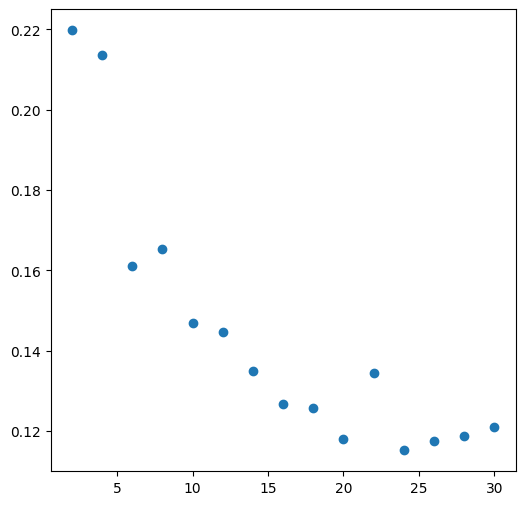

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rasterio
import rioxarray as rx
from PIL import Image
import imagecodecs
import os

isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)


test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  print(shp)
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  print(cluster_labels.shape)
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)




###Silhouette score/One breakpoint

Optimal breakpoint 1: 4.262626262626263


/tmp/ipython-input-2686950674.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


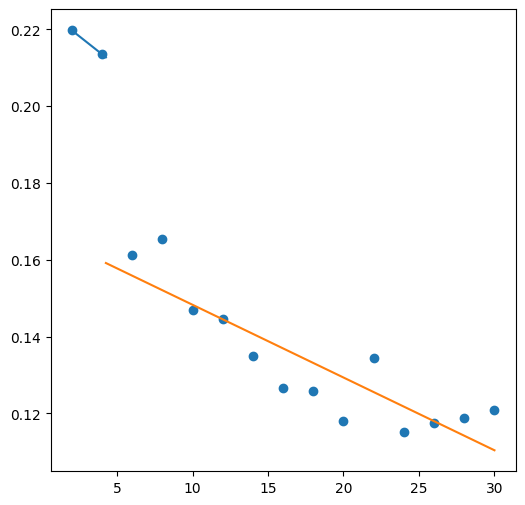

In [3]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Davies-Bouldin score/No breakpoint

(1281, 2042)
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.6446426492483763
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.4380084486704776
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.6296086845541327
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.5504116252014617
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.7048773476649597
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.742543800592248
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.743913738425386
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.741963883212906
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.7272458207949986
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.7243466356548047
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.669304421878911
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.7167569713864144
(13, 1281, 2042)
(1, 1281, 2042)
Davies Bouldin Index: 1.7146247310851157
(13, 1281, 2042)
(1, 1281, 20

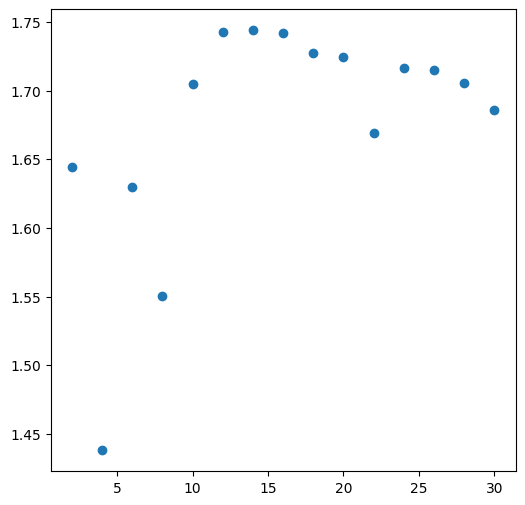

In [4]:
import torch
from torchmetrics.clustering import DunnIndex
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rasterio
import rioxarray as rx
import imagecodecs
import os
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = None
dunn_index = DunnIndex(p=2)


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  print(shp)
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  print(arr.shape)
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  score = davies_bouldin_score(X, cluster_labels)
  test_scores.append(score)

  print(f"Davies Bouldin Index: {score.item()}")

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)


###Davies-Bouldin score/One breakpoint

Optimal breakpoint 1: 8.222222222222221


/tmp/ipython-input-3575090378.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


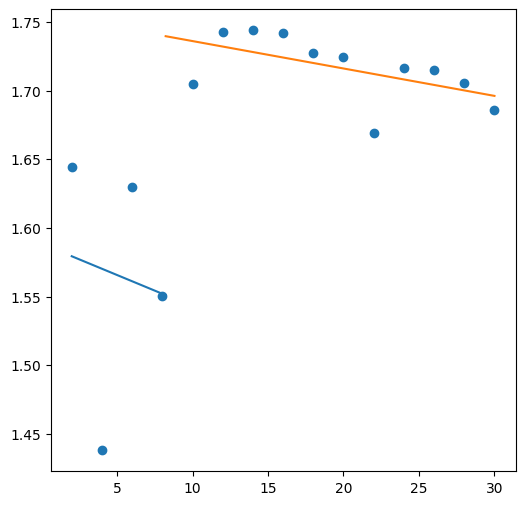

In [5]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Purity score/No breakpoint

In [6]:

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

purity_list = []
for key in sorted_dict:
  df = sorted_dict[key]
  sum = df.iloc[:, 1:].sum().sum()
  max_values_per_row = df.iloc[:, 1:].max(axis=1)
  purity = max_values_per_row.sum()/sum
  purity_list.append(purity)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, purity_list)



['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,277994,72208,424,1211,107563,531,158698,15471,92041,18948,48917,0,31670,7952,123796
1,2,167052,4213,4111,64628,41017,39124,39356,140483,8123,26773,52298,1398,22594,53807,1042


NameError: name 'sorted_dict' is not defined

In [ ]:
'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

purity_list = []
for key in sorted_dict:
  df = sorted_dict[key]
  sum = df.iloc[:, 1:].sum().sum()
  max_values_per_row = df.iloc[:, 1:].max(axis=1)
  purity = max_values_per_row.sum()/sum
  purity_list.append(purity)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, purity_list)



### Test

In [ ]:
!pip install permetrics

['Zonal_eco3_6.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_30.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_2.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_14.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,77186,2016,2,42,64463,73,63123,832,28618,4,169,0,325,722,1
1,2,3705,67948,0,11,2006,0,6991,1507,10193,0,2,0,6503,1,119682
2,3,182927,1833,241,1065,37464,57,77733,2114,12846,1,338,0,912,7708,11
3,4,1380,1488,0,160,659,770,11918,56039,47321,45713,98101,1,42840,0,4990
4,5,159181,2786,3606,10759,31453,7057,35716,27894,727,3,1560,333,301,43254,122
5,6,20667,350,686,53802,12535,31698,2573,67568,459,0,1045,1064,3383,10074,32


1623443
1623443
[np.float64(0.7678692753610691), np.float64(0.7507544151534732), np.float64(0.5837716507447444), np.float64(0.5566669110033429), np.float64(0.513306595919906), np.float64(0.4693081309291426), np.float64(0.40593171426406716), np.float64(0.37407349688285946), np.float64(0.3909764617544318), np.float64(0.3683313796665482), np.float64(0.4047422668981911), np.float64(0.41821979582898816), np.float64(0.4501414586160401), np.float64(0.4527063777416269), np.float64(0.5072010535633219)]


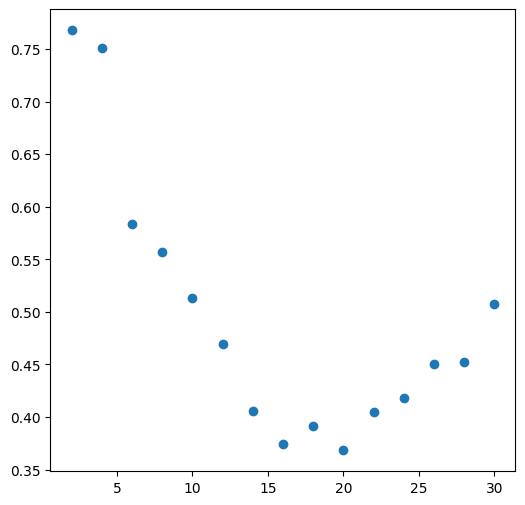

In [ ]:
from permetrics import ClusteringMetric

'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

arr = df.iloc[:, 1:].to_numpy()


scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco3_{}.csv'.format(n)))
  arr = df.iloc[:, 1:].to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  scores.append(cm.purity_score())

print(len(y_true))
print(len(y_pred))
print(scores)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, scores)


###Purity score/One breakpoint

Optimal breakpoint 1: 14.16161616161616


/tmp/ipython-input-2479505352.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


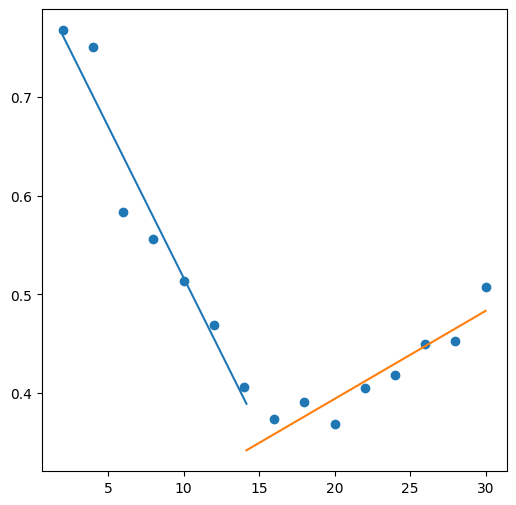

In [ ]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])



###Entropy score/No breakpoint

,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,77186,2016,2,42,64463,73,63123,832,28618,4,169,0,325,722,1
1,2,3705,67948,0,11,2006,0,6991,1507,10193,0,2,0,6503,1,119682
2,3,182927,1833,241,1065,37464,57,77733,2114,12846,1,338,0,912,7708,11
3,4,1380,1488,0,160,659,770,11918,56039,47321,45713,98101,1,42840,0,4990
4,5,159181,2786,3606,10759,31453,7057,35716,27894,727,3,1560,333,301,43254,122
5,6,20667,350,686,53802,12535,31698,2573,67568,459,0,1045,1064,3383,10074,32


/tmp/ipython-input-1822058004.py:32: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-1822058004.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


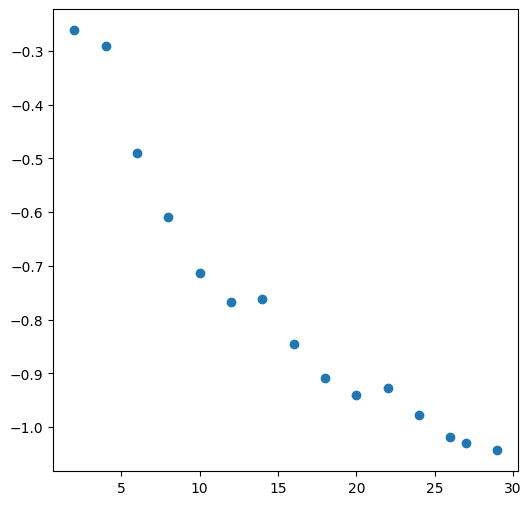

In [ ]:
fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

entropy_list = []
for key in sorted_df_dict:
  df = sorted_dict[key]
  df_sum = df.iloc[:, 1:].sum().sum()
  sum_values_per_col = df.iloc[:, 1:].sum(axis=0)
  entropy = 0
  for i, col_sum in enumerate(sum_values_per_col[:1]):
    sr = df.iloc[:, i+1].divide(col_sum)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (col_sum/df_sum)
    entropy += col_entropy

  entropy_list.append(entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, entropy_list)


###Entropy score/One breakpoint

Optimal breakpoint 1: 10.181818181818182


/tmp/ipython-input-3818795856.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


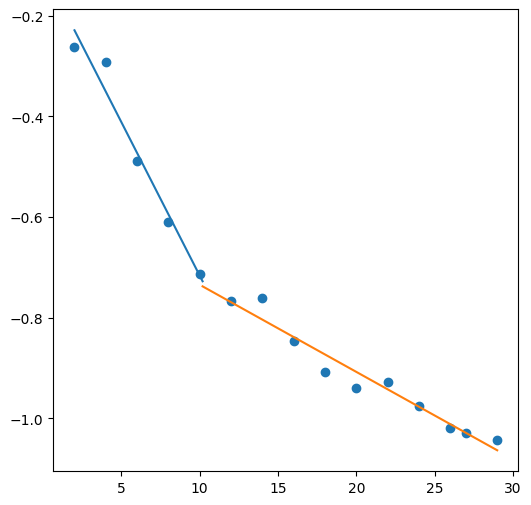

In [ ]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in entropy_list])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])



In [ ]:
!pip install permetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.9 MB/s eta 0:00:00


{2:    LABEL  US_L3_13  US_L3_14  US_L3_18  US_L3_19  US_L3_20  US_L3_21  \
0      1    277994     72208       424      1211    107563       531   
1      2    167052      4213      4111     64628     41017     39124   

   US_L3_22  US_L3_23  US_L3_24  US_L3_25  US_L3_26  US_L3_5  US_L3_79  \
0    158698     15471     92041     18948     48917        0     31670   
1     39356    140483      8123     26773     52298     1398     22594   

   US_L3_80  US_L3_81  
0      7952    123796  
1     53807      1042  , 4:    LABEL  US_L3_13  US_L3_14  US_L3_18  US_L3_19  US_L3_20  US_L3_21  \
0      1    296787      2714       828      2295    106982       963   
1      2      7557     69132         0        16      3517         0   
2      3      3155      2099         0       168      2170      1079   
3      4    137547      2476      3707     63360     35911     37613   

   US_L3_22  US_L3_23  US_L3_24  US_L3_25  US_L3_26  US_L3_5  US_L3_79  \
0    150779      5259     24216         0    

/tmp/ipython-input-495697485.py:37: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-495697485.py:37: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


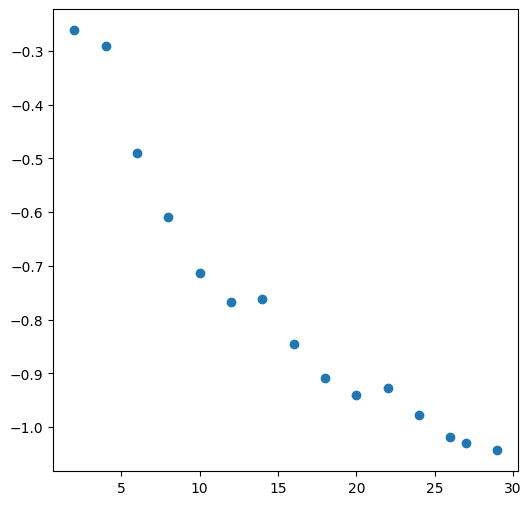

In [ ]:
import numpy as np
from permetrics import ClusteringMetric


fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']

df = pd.read_csv(os.path.join(fld, files[0]))

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

print(sorted_df_dict)

entropy_list = []
for key in sorted_df_dict:

  df = sorted_df_dict[key]
  df_sum = df.iloc[:, 1:].sum().sum()
  sum_values_per_col = df.iloc[:, 1:].sum(axis=0)
  entropy = 0
  for i, col_sum in enumerate(sum_values_per_col[:1]):
    sr = df.iloc[:, i+1].divide(col_sum)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (col_sum/df_sum)
    entropy += col_entropy

  entropy_list.append(entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, entropy_list)


